In [1]:
from typing import Union, List, Text
from diffusers import AutoPipelineForInpainting, ControlNetModel, StableDiffusionControlNetInpaintPipeline
from diffusers.utils import load_image, make_image_grid, numpy_to_pil
import torch
import numpy as np
import PIL
from PIL import Image, ImageShow, ImageFilter
from transformers import SegformerImageProcessor, AutoModelForSemanticSegmentation
import requests
import matplotlib.pyplot as plt
import torch.nn as nn
import cv2
from IPython.core.debugger import Pdb
from controlnet_aux import OpenposeDetector

/workspace/hosjiu/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/workspace/hosjiu/venv/lib/python3.10/site-packages/diffusers/models/vq_model.py:20: FutureWarning: `VQEncoderOutput` is deprecated and will be removed in version 0.31. Importing `VQEncoderOutput` from `diffusers.models.vq_model` is deprecated and this will be removed in a future version. Please use `from diffusers.models.autoencoders.vq_model import VQEncoderOutput`, instead.
  deprecate("VQEncoderOutput", "0.31", deprecation_message)
/workspace/hosjiu/venv/lib/python3.10/site-packages/diffusers/models/vq_model.py:25: FutureWarning: `VQModel` is deprecated and will be removed in version 0.31. Importing `VQModel` from `diffusers.models.vq_model` is deprecated and this will be removed in a future version. Please use `from diffusers.mo

In [2]:
# Utilities
def show(image: Union[str, PIL.Image.Image], downsize_ratio: int = 1):
    if isinstance(image, PIL.Image.Image):
        pass
    else:
        image = Image.open(img_path)
    viewer = ImageShow.IPythonViewer()
    width = image.width // downsize_ratio
    height = image.height // downsize_ratio
    resized_img = image.resize((width, height))
    viewer.show(image=resized_img)

# Reference: 
# https://github.com/huggingface/diffusers/issues/3514#issuecomment-1565221994
# https://github.com/Markus-Pobitzer/Inpainting-Tutorial/tree/main
def mask_dilation(mask, kernel_size=10):
    mask = mask.astype(np.uint8)
    mask = cv2.dilate(
        mask,
        np.ones((kernel_size, kernel_size), np.uint8),
        iterations=1
    )
    return mask

def blend_images(img1, img2, mask, blur=3, dilate=0):
    if dilate:
        mask = numpy_to_pil(mask_dilation(np.array(mask) // 255, dilate) * 255)[0]
    mask = mask.convert('L').filter(ImageFilter.GaussianBlur(blur))
    img1 = img1.convert('RGBA')
    img2 = img2.convert('RGBA')
    blended_img = Image.composite(img1, img2, mask)
    return blended_img

In [3]:
# Load ControlNet for Human Pose
controlnet = ControlNetModel.from_pretrained(
    'lllyasviel/sd-controlnet-openpose',
    torch_dtype=torch.float16
).to('cuda')

In [4]:
# Load SD Inpaiting Pipeline
inpainting_base_model = 'runwayml/stable-diffusion-inpainting'
pipeline = StableDiffusionControlNetInpaintPipeline.from_pretrained(
    inpainting_base_model, 
    variant='fp16',
    torch_dtype=torch.float16,
    controlnet=controlnet,
    safety_checker=None
).to('cuda')

Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 11.85it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet_inpaint.StableDiffusionControlNetInpaintPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [5]:
# Load IP-Adapter Inpainting pipeline
ip_adapter_model = 'h94/IP-Adapter'
pipeline.load_ip_adapter(ip_adapter_model, subfolder='models', weight_name='ip-adapter_sd15.bin')
pipeline.set_ip_adapter_scale(1.0)

In [6]:
class Masker:
    def __init__(self, model_id='mattmdjaga/segformer_b2_clothes'): # SegFormer
        self.processor = SegformerImageProcessor.from_pretrained(model_id)
        self.model = AutoModelForSemanticSegmentation.from_pretrained(model_id)

    def get_binary_mask(self, image, return_pil=False):
        inputs = self.processor(images=image, return_tensors="pt")        
        outputs = self.model(**inputs)
        logits = outputs.logits.cpu()
        upsampled_logits = nn.functional.interpolate(
            logits,
            size=image.size[::-1],
            mode="bilinear",
            align_corners=False
        )
        pred_seg = upsampled_logits.argmax(dim=1)[0] # Dunno how this line work
        np_image = np.array(image)
        np_image[pred_seg != 4] = 0
        np_image[pred_seg == 4] = 255
        binary_mask = ((pred_seg == 4) * 255).numpy().astype(np.uint8)

        return Image.fromarray(binary_mask) if return_pil else binary_mask

In [7]:
masker = Masker()

/workspace/hosjiu/venv/lib/python3.10/site-packages/transformers/models/segformer/image_processing_segformer.py:103: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [8]:
image = load_image('../images/male_model.jpg')
# image = load_image('https://raw.githubusercontent.com/tencent-ailab/IP-Adapter/main/assets/inpainting/image.png')

ip_image = load_image('../data/img1.jpg')
# ip_image = load_image('https://raw.githubusercontent.com/tencent-ailab/IP-Adapter/main/assets/images/girl.png')

mask_image = masker.get_binary_mask(image, return_pil=True)
# mask_image = load_image('https://raw.githubusercontent.com/tencent-ailab/IP-Adapter/main/assets/inpainting/mask.png')

In [9]:
INPUT_IMAGE_SIZE = (512, 768)
SQUARE_IMAGE_SIZE = (224, 224)
image = image.resize(INPUT_IMAGE_SIZE)
mask_image = mask_image.resize(INPUT_IMAGE_SIZE)
# ip_image = ip_image.resize(SQUARE_IMAGE_SIZE)

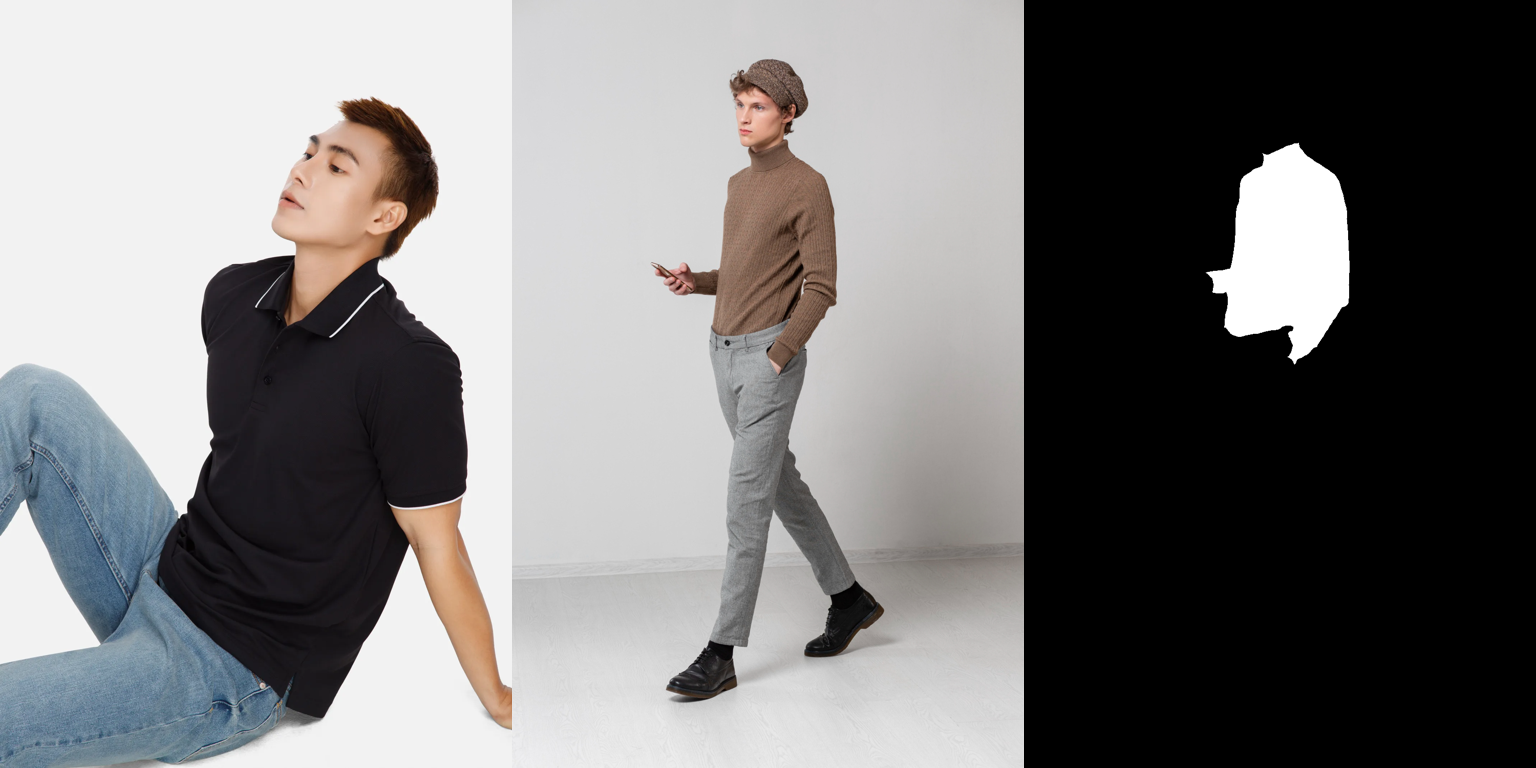

In [10]:
make_image_grid([ip_image.resize(INPUT_IMAGE_SIZE), image, mask_image], rows=1, cols=3)

In [11]:
def try_on(original_image: PIL.Image.Image, 
           mask_image: PIL.Image.Image,
           ip_image: PIL.Image.Image,
           prompt: Text,
           control_image: Union[PIL.Image.Image],
           use_controlnet: bool = False,
           **kwargs) -> List[PIL.Image.Image]:
    if use_controlnet:
        images = pipeline(
            prompt=prompt,
            image=original_image,
            mask_image=mask_image,
            control_image=control_image,
            width=kwargs.get('width'), # output width
            height=kwargs.get('height'), # output height
            ip_adapter_image=ip_image,
            generator=kwargs.get('seed'),
            num_images_per_prompt=kwargs.get('num_images'),
            strength=kwargs.get('strength'),
            num_inference_steps=kwargs.get('num_inference_steps'),
            padding_mask_crop=kwargs.get('padding_mask_crop')
        ).images
    else:
        images = pipeline(
            prompt=prompt,
            image=original_image,
            mask_image=mask_image,
            width=kwargs.get('width'), # output width
            height=kwargs.get('height'), # output height
            ip_adapter_image=ip_image,
            generator=kwargs.get('seed'),
            num_images_per_prompt=kwargs.get('num_images'),
            strength=kwargs.get('strength'),
            num_inference_steps=kwargs.get('num_inference_steps'),
            padding_mask_crop=kwargs.get('padding_mask_crop')
        ).images

    return images

In [17]:
pipe_config = {
    'num_images': 3,
    'strength': 1,
    'num_inference_steps': 100,
    'seed': torch.Generator(device="cuda").manual_seed(3),
    'width': INPUT_IMAGE_SIZE[0],
    'height': INPUT_IMAGE_SIZE[1],
    'padding_mask_crop': 32
}

In [ ]:
images = try_on(image, mask_image, ip_image, prompt="", **pipe_config)

/workspace/hosjiu/venv/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 100/100 [01:00<00:00,  1.65it/s]


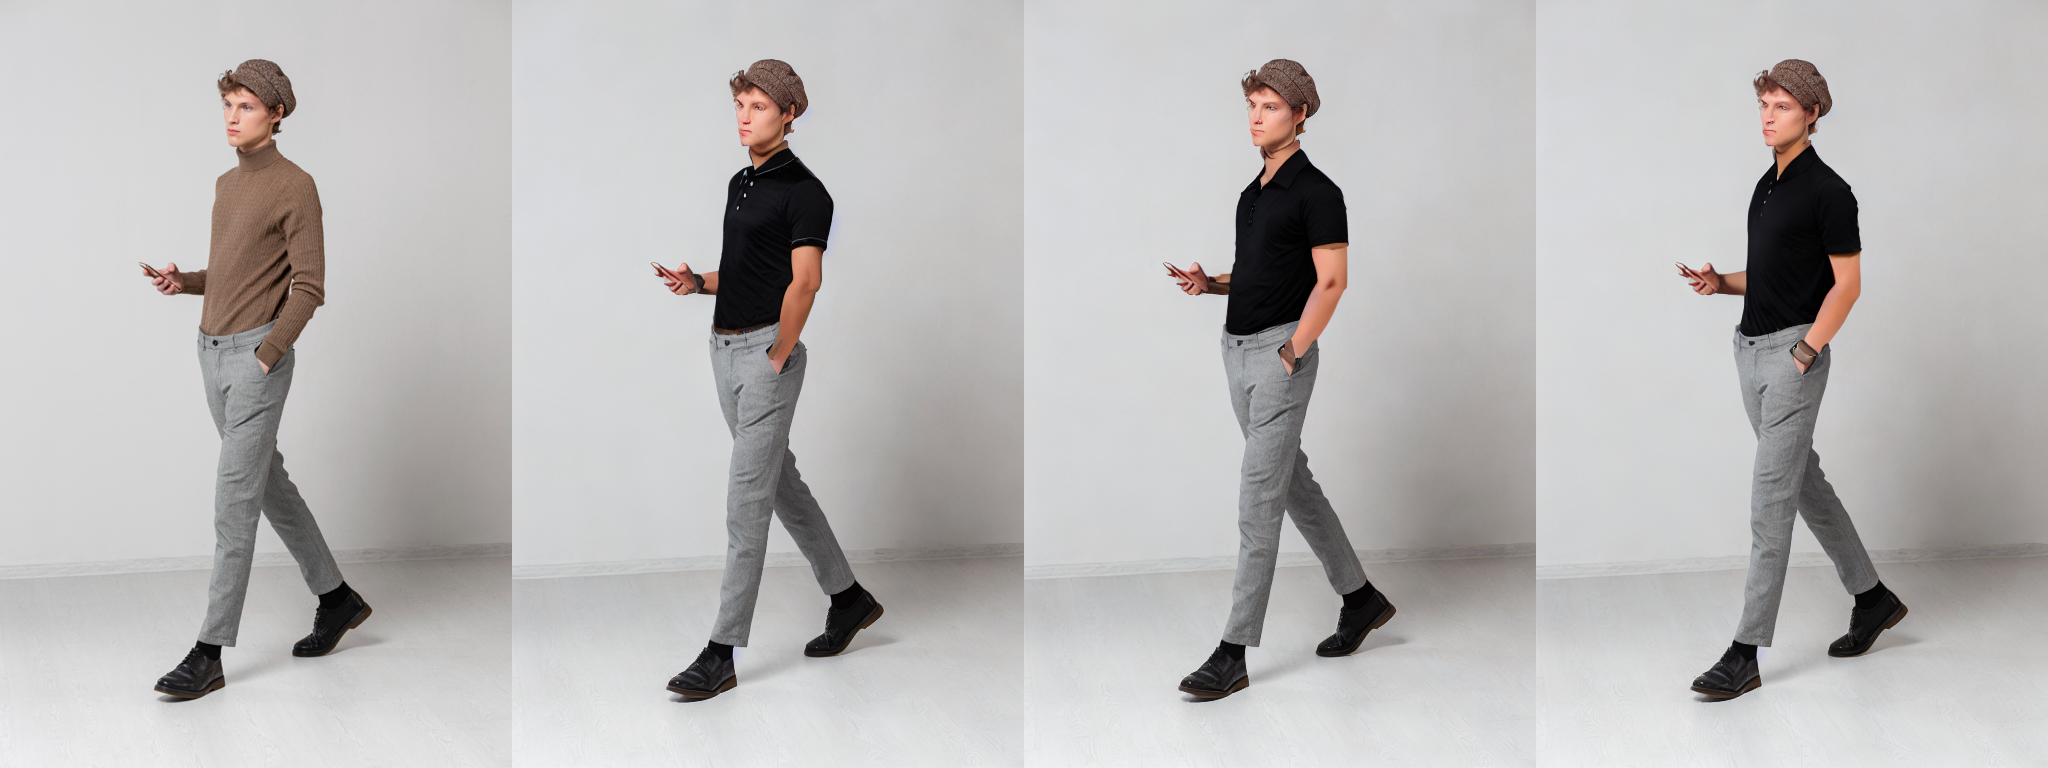

In [12]:
make_image_grid([image] + images, rows=1, cols=num_images + 1)

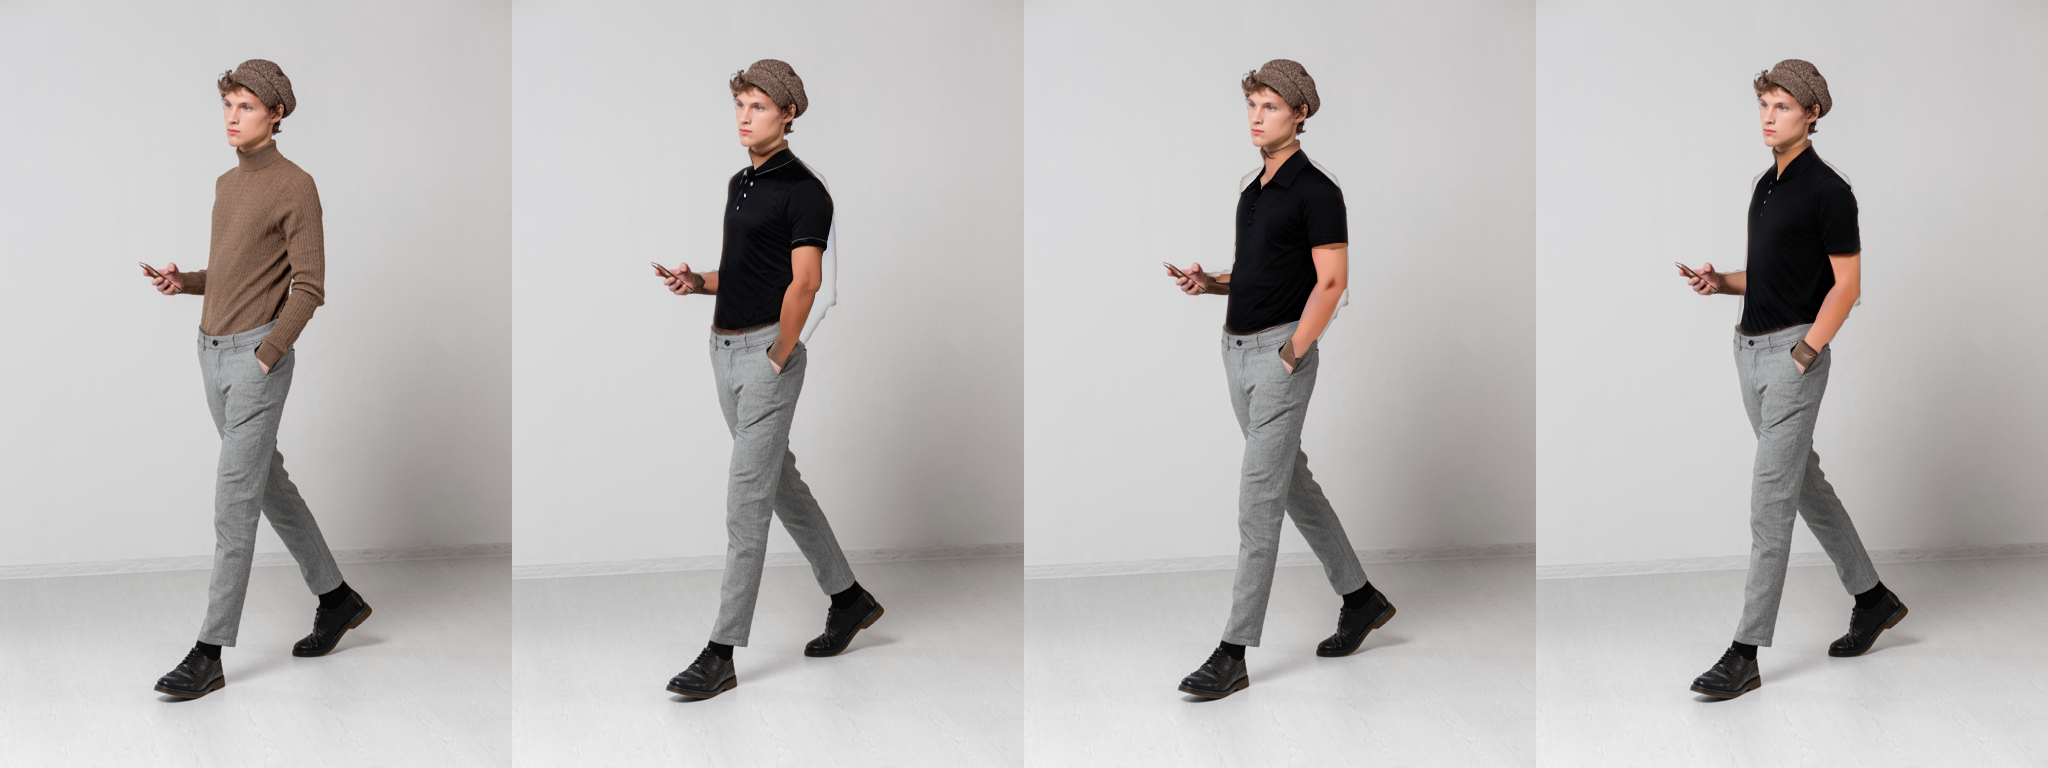

In [31]:
# Blending the original image with the inpainted on based on the mask
# Restore the original unmasked area changed due to VAE process loss the original image
blended_images = [blend_images(inpainted_img, image, mask_image, dilate=0) for inpainted_img in images]
make_image_grid([image] + blended_images, rows=1, cols=num_images + 1)

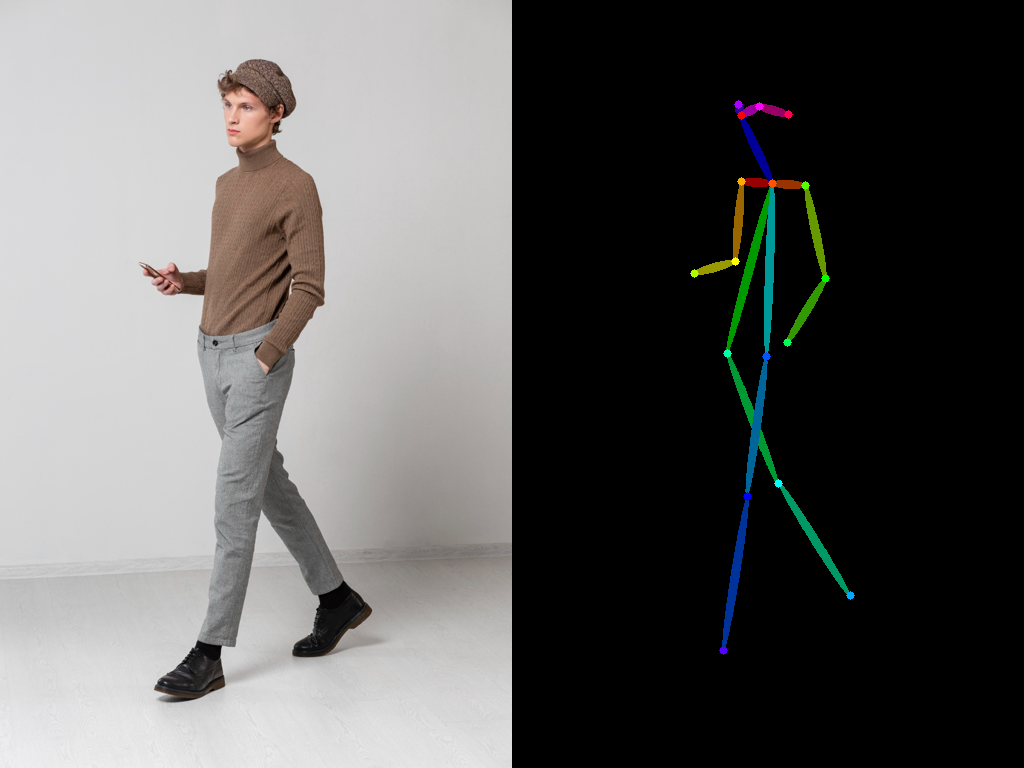

In [14]:
openpose = OpenposeDetector.from_pretrained('lllyasviel/ControlNet')
pose = openpose(image)
make_image_grid([image, pose], rows=1, cols=2)

In [15]:
# w/ ControlNet (Pose)
images = try_on(image, mask_image, ip_image, prompt="", control_image=pose, use_controlnet=True, **pipe_config)

/workspace/hosjiu/venv/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
100%|██████████| 100/100 [01:23<00:00,  1.20it/s]


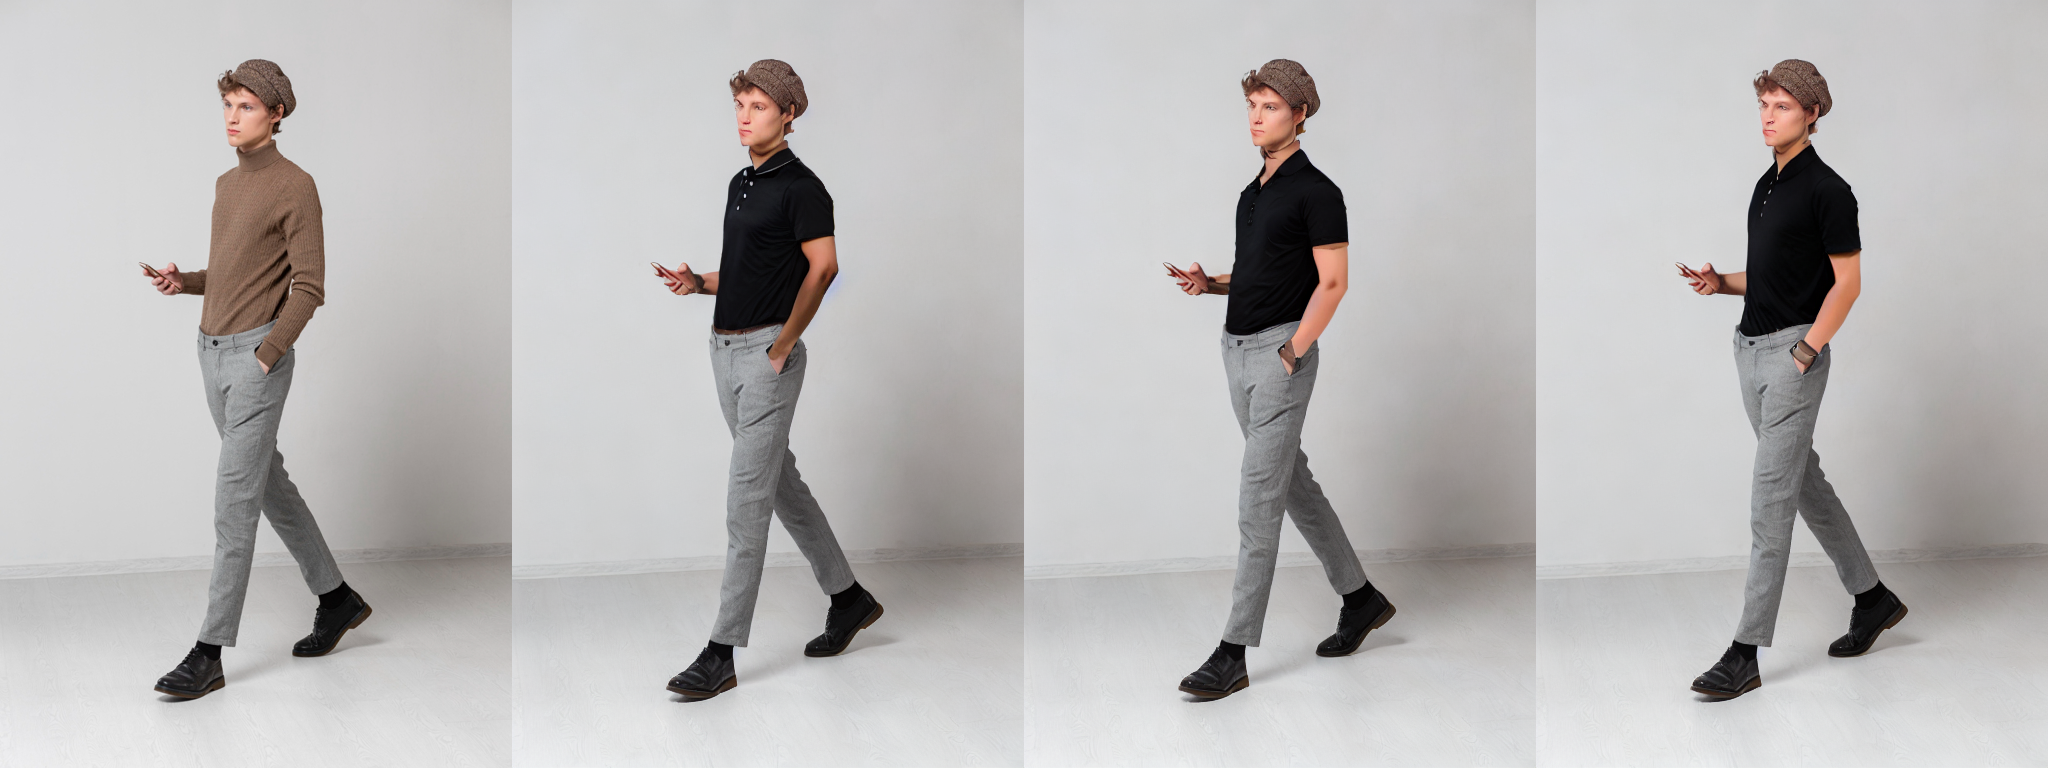

In [16]:
make_image_grid([image] + images, rows=1, cols=pipe_config['num_images'] + 1)

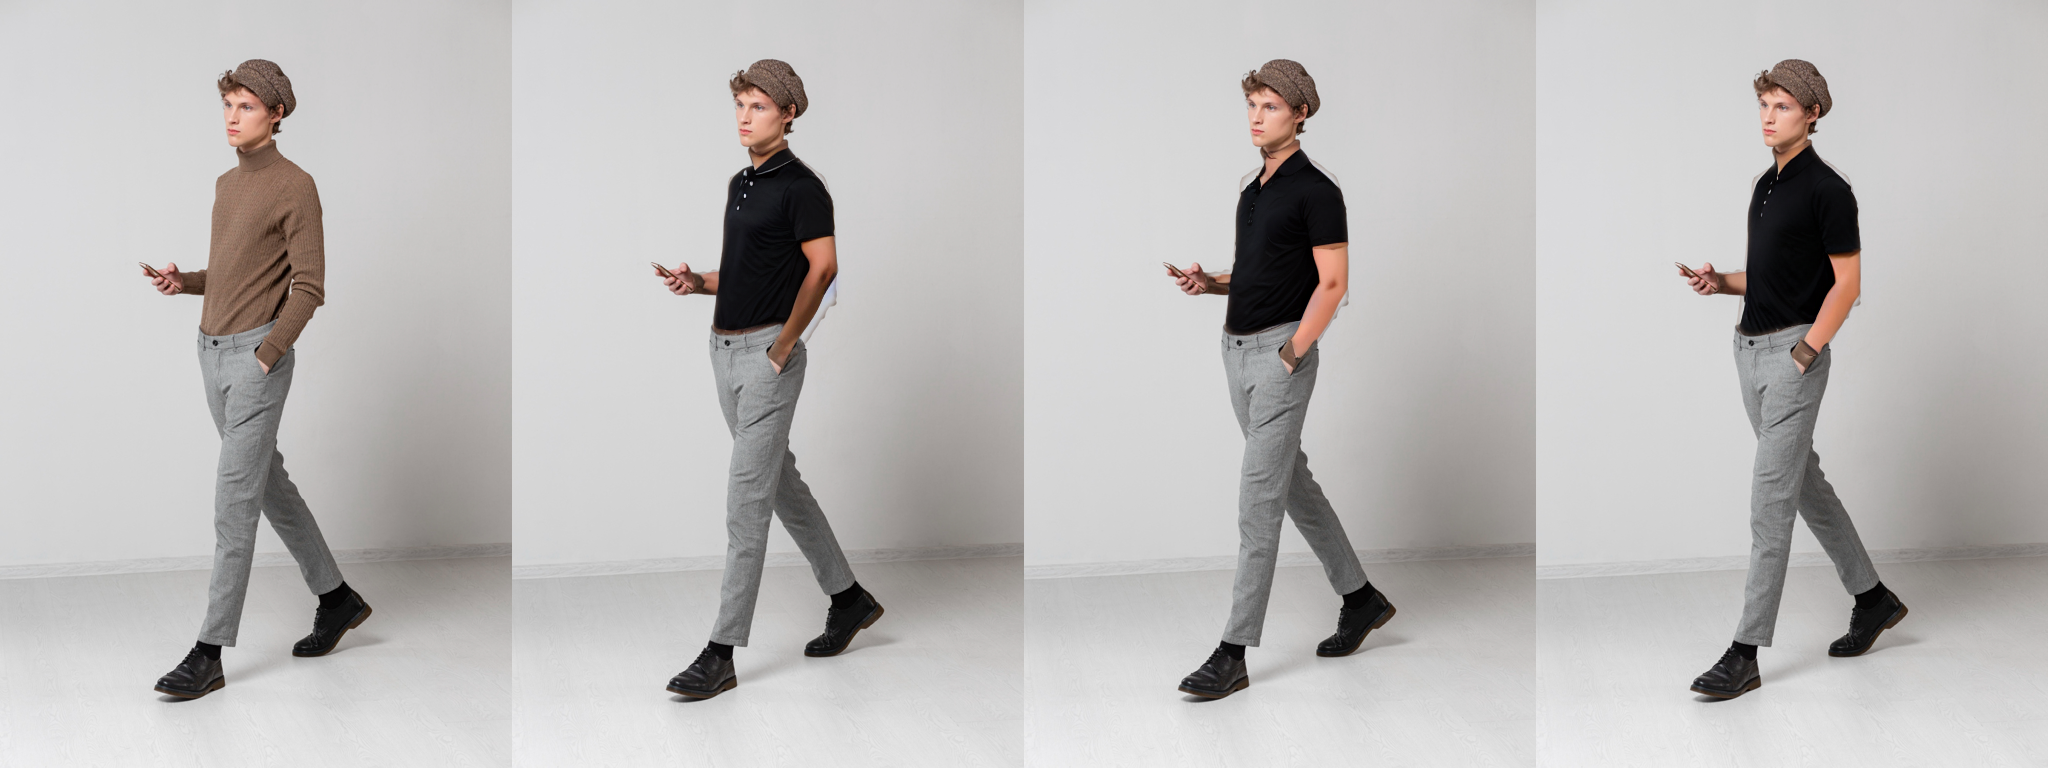

In [17]:
blended_images = [blend_images(inpainted_img, image, mask_image, dilate=0) for inpainted_img in images]
make_image_grid([image] + blended_images, rows=1, cols=pipe_config['num_images'] + 1)

In [18]:
# w/ padding_mask_crop + human pose controlnet
images = try_on(
    image, mask_image, ip_image,
    prompt="",
    control_image=pose,
    use_controlnet=True,
    **pipe_config
)

100%|██████████| 100/100 [01:24<00:00,  1.19it/s]


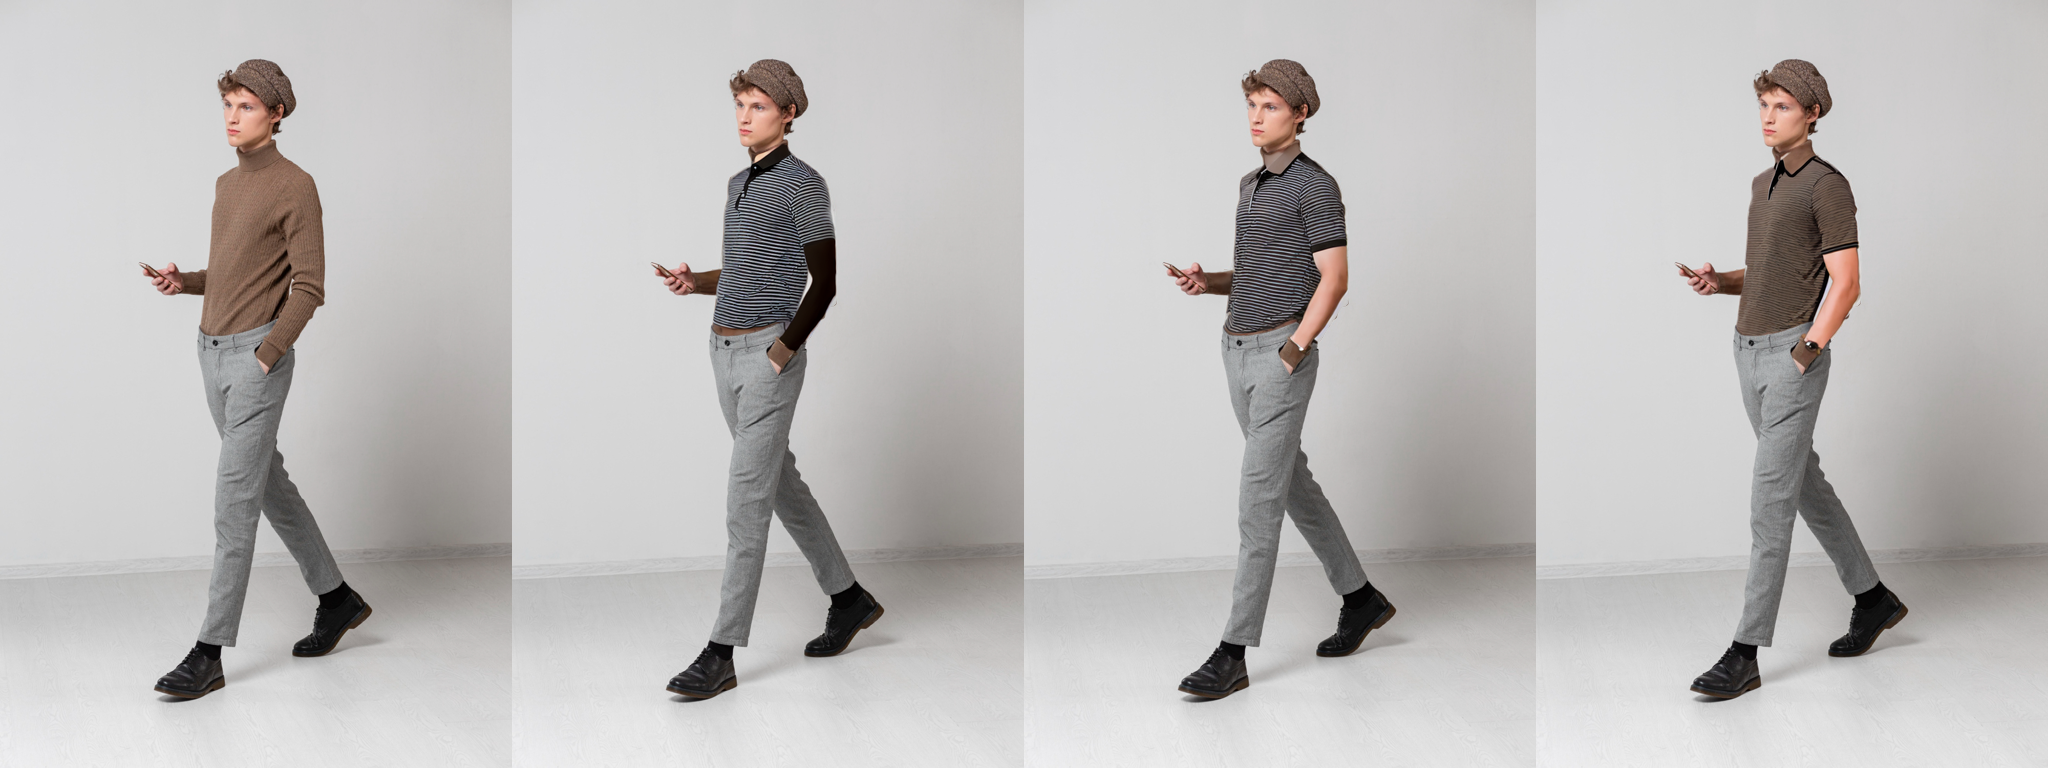

In [19]:
make_image_grid([image] + images, rows=1, cols=pipe_config['num_images'] + 1)